In [1]:
import scipy.io as sio
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import astropy.convolution
import seaborn as sns
from astropy.modeling.models import Gaussian2D
import math
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


In [2]:
squeezed = sio.loadmat('RFfit.mat', squeeze_me=True)

In [3]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [4]:
def multivariate_gaussian(pos, mu, Sigma):

    """Return the multivariate Gaussian distribution on array pos.

 

    pos is an array constructed by packing the meshed arrays of variables

    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

 
    """
 
    #Sigma is np.array([[ std_av, 1], [1, std_av]])
    
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma) # Compute the determinant of an array.
    Sigma_inv = np.linalg.inv(Sigma) # Compute the (multiplicative) inverse of a matrix.
    N = np.sqrt(((2*np.pi)**n) * Sigma_det)

    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized

    # way across all the input variables.

    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N


0.12719582086231254


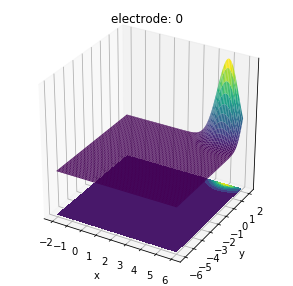

0.8376206729017407


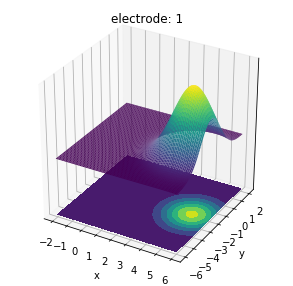

0.7873038746424348


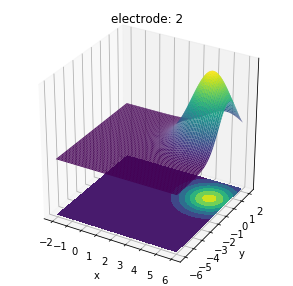

0.899964336885293


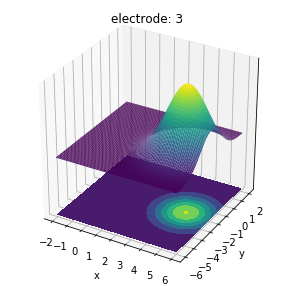

0.7696887708256178


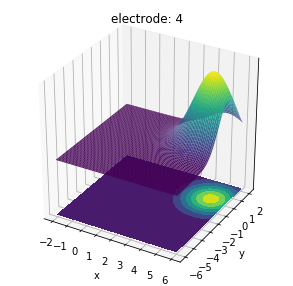

0.8004435689028668


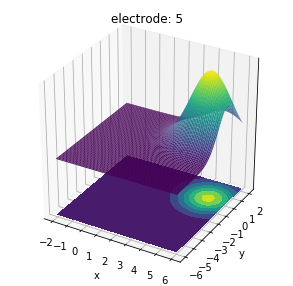

0.7844773376116486


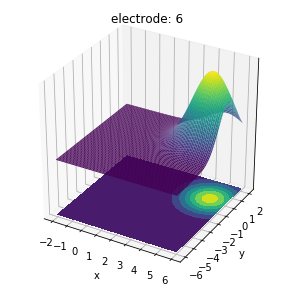

0.9953474528061426


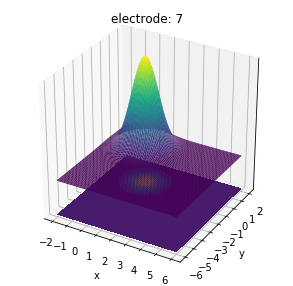

0.7978806793513793


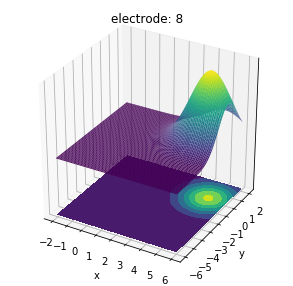

0.7822188216795224


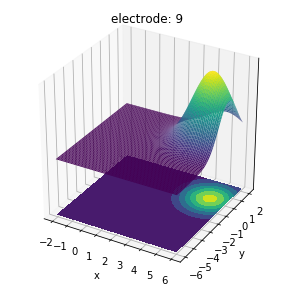

0.7790066530703591


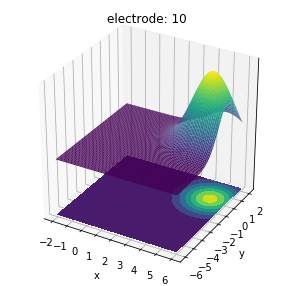

0.9564151166063227


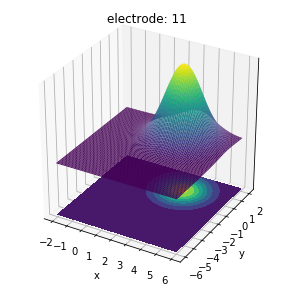

0.8005533896823976


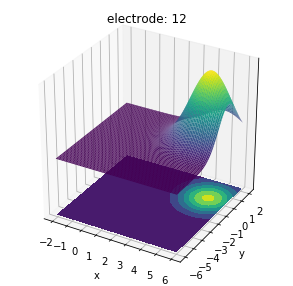

0.8026683726641309


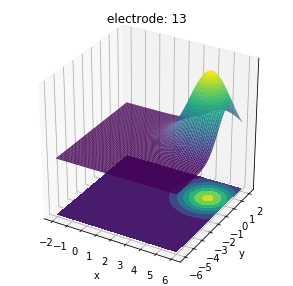

0.7794336965748133


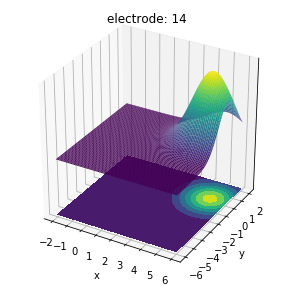

0.16194536257628572


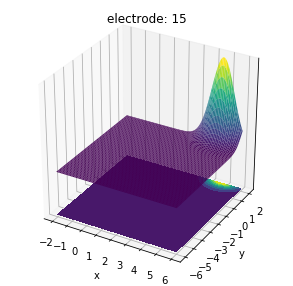

0.1391136855465678


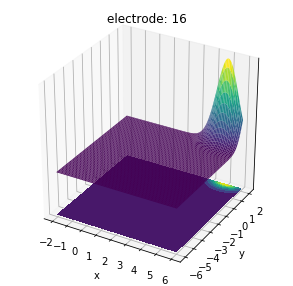

0.7708561797386546


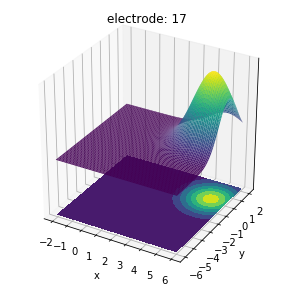

0.8427876314199885


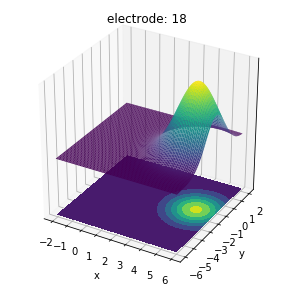

0.7900128322878518


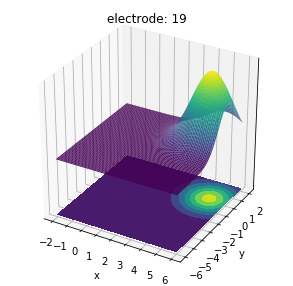

0.7941041770902171


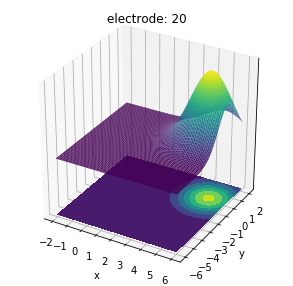

0.9481891297784796


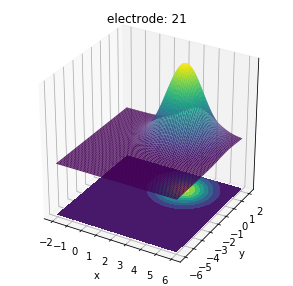

0.7894343222342032


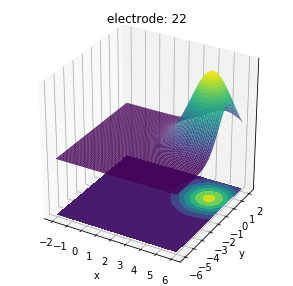

0.7916074622274127


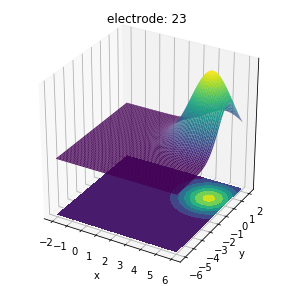

0.997334945092323


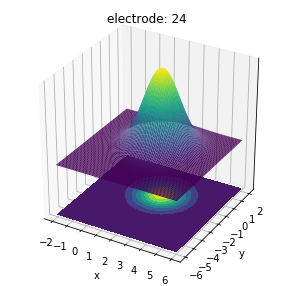

0.9952569597601514


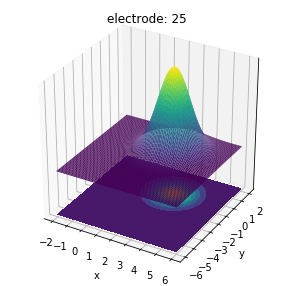

0.9965659204322062


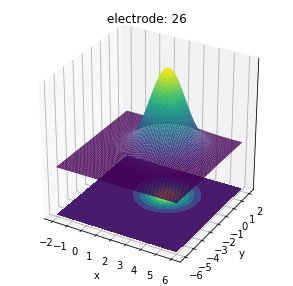

0.9964491663214275


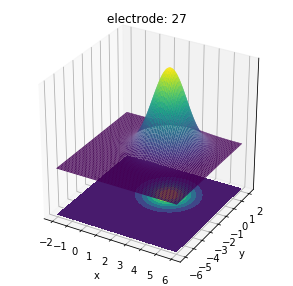

0.9969787075592859


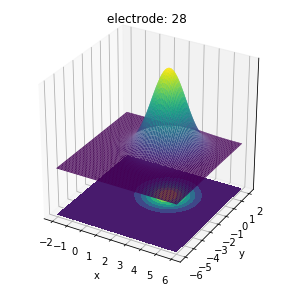

0.9963937679065261


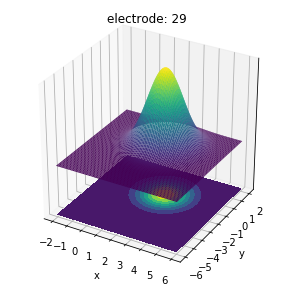

0.9954608429532755


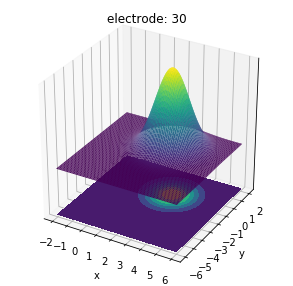

0.9961334033869736


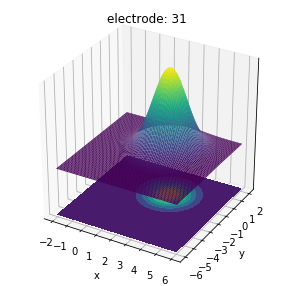

0.9964624137211445


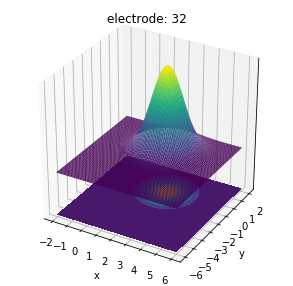

0.9953785499177921


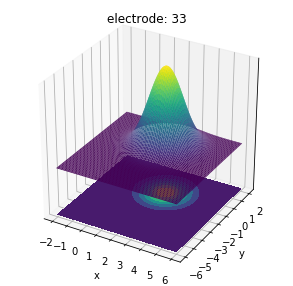

0.9957014990783638


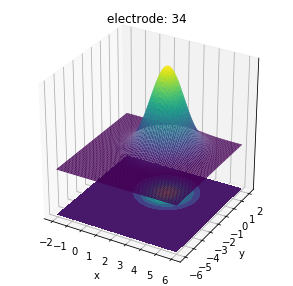

0.9958468799603613


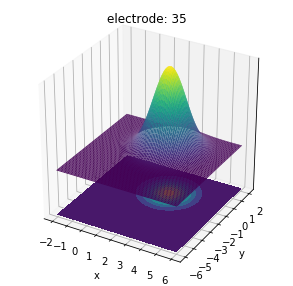

0.9943027570521497


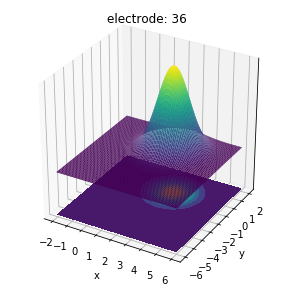

0.9946621630391799


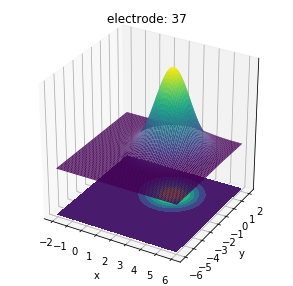

0.994960779306246


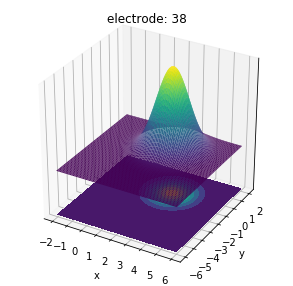

0.9906166678485752


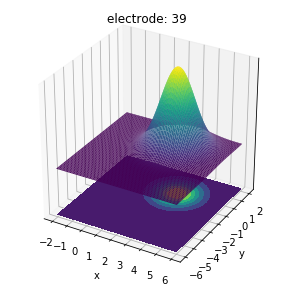

0.9960263067244345


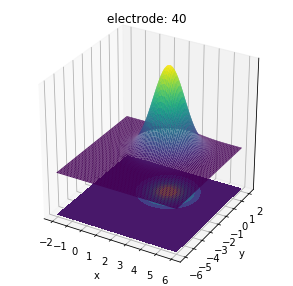

0.9963747685322337


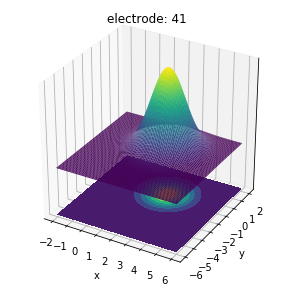

0.9972352538618583


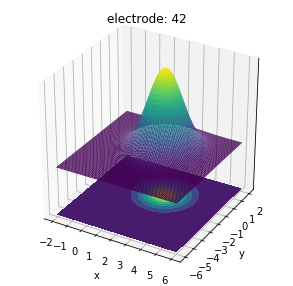

0.9969597653077316


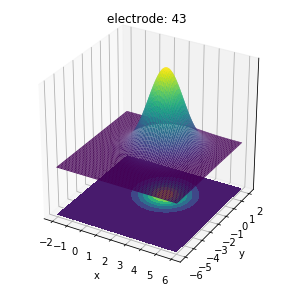

0.9962664077212003


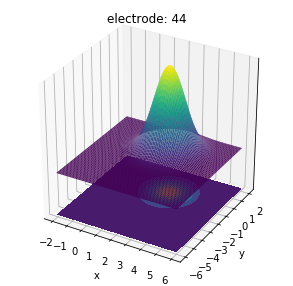

0.9954520841706802


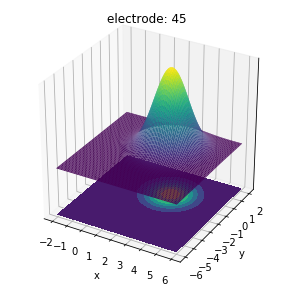

0.9964497681878078


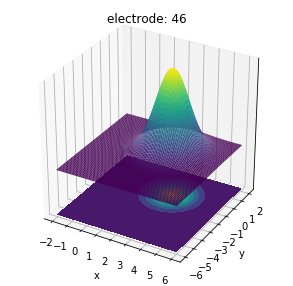

0.9959686843063189


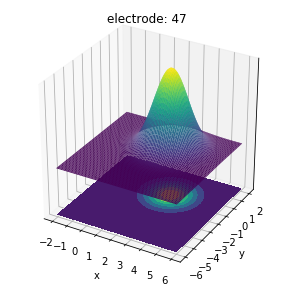

0.9697289994113477


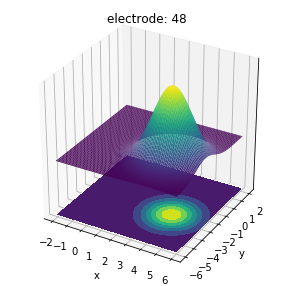

0.9610571249097377


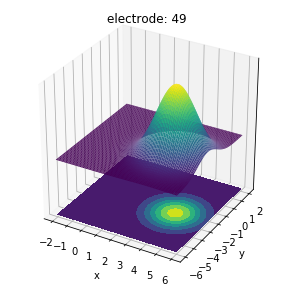

0.9408882112601956


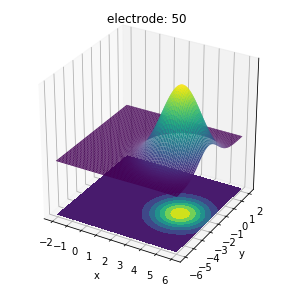

0.9567376602788069


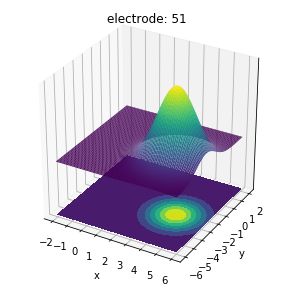

0.9493955254044196


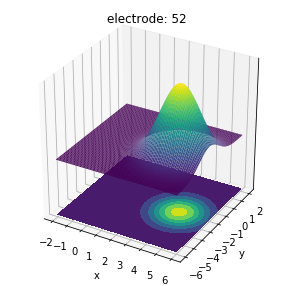

0.9713734559060636


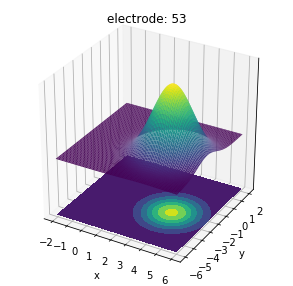

0.9523780047817789


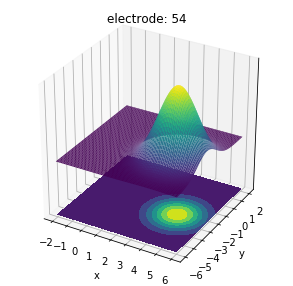

0.9594399138182392


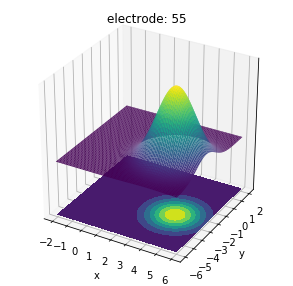

0.964415288986098


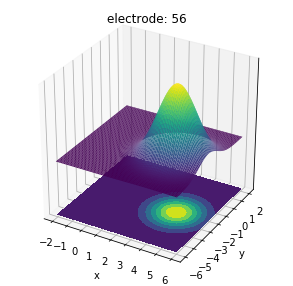

0.9759390757415154


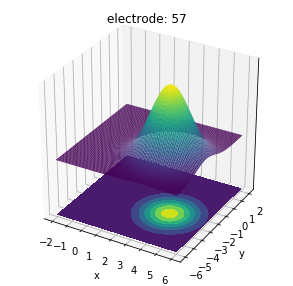

0.9693461340284287


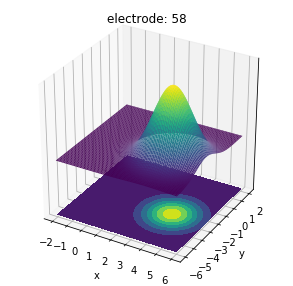

0.934267304270807


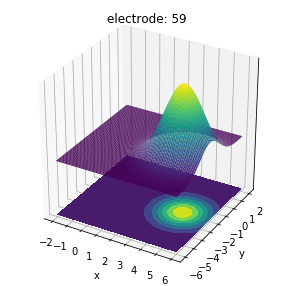

0.9681571017423277


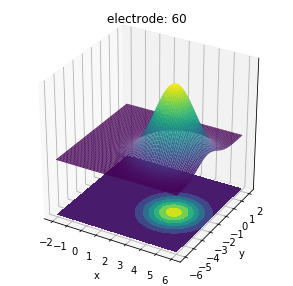

0.9786433983106337


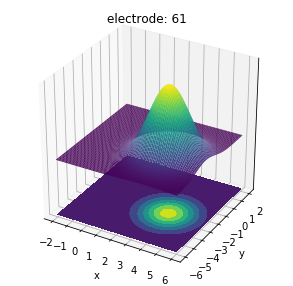

0.976830543102015


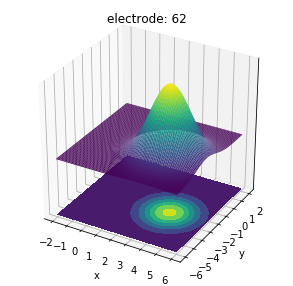

0.9502431854213518


In [ ]:
gaussians_list=[]

for electrodes in range(192):

    # electrodes = 40
    elec_data = squeezed['Elec']
    fit = 2 #Always 2 to obtain fitt info
    horizontal = 0
    vertical = 1
    signal = 0
    vis_angle = 1

    horizontal_cor = elec_data[electrodes][0][horizontal][fit]
    vertical_cor = elec_data[electrodes][0][vertical][fit]

    hori_signal = horizontal_cor.flatten()[0][signal]
    hori_visual_angle = horizontal_cor.flatten()[0][vis_angle]

    verti_signal = vertical_cor.flatten()[0][signal]
    verti_visual_angle = vertical_cor.flatten()[0][vis_angle]

    prob_hori = hori_signal - hori_signal.min()
    prob_verti = verti_signal - verti_signal.min()

    hori_mean, hori_std = weighted_avg_and_std(hori_visual_angle, prob_hori)
    verti_mean, verti_std = weighted_avg_and_std(verti_visual_angle, prob_verti)

    N = 600
    X = np.linspace(-7.5, 12.5, N)
    Y = np.linspace(-12.5, 7.5, N)
    X, Y = np.meshgrid(X, Y)
    std_av = (hori_std + verti_std)/2

    # Mean vector and covariance matrix
    mu = np.array([hori_mean, verti_mean])
    Sigma = np.array([[ std_av, 0], [0, std_av]]) # the zeros are the covariance matrix (correlation between x and y)
    #In our case it is not needded so et to 0

# Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    Z = (Z/Z.sum())
    
    img_width = Z.shape[0]
    left_e = int((img_width / 100 * 27.5))
    right_s = int(img_width - (img_width/100*32.5))

    img_height = Z.shape[1]
    top_e = int((img_height / 100 * 27.5))
    bot_s = int(img_height - (img_height/100*32.5))
    
    Z_cropped = Z[left_e:right_s, top_e:bot_s]
    
    Z = Z_cropped
    gaussians_list.append(Z)
    
    print(Z.sum())

    # ------------------- -
    # PLOTTING
    # ------------------- -
    N = 240

    X = np.linspace(-2, 6, N)
    Y = np.linspace(-6, 2, N)
    X, Y = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,

                    cmap=cm.viridis)

    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.0001, cmap=cm.viridis)

    ax.set_zlim(-0.0001,Z.max())
    ax.set_zticks([])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('electrode: ' +  str(electrodes))
    plt.show()


In [44]:
np.save('multivariate_gaussians240_cropped.npy', gaussians_list)

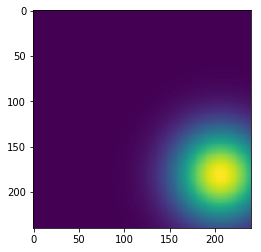

In [39]:
plt.imshow(gaussians_list[2])

In [42]:
gaussians_list[2].sum()

0.7873038746424348